## 8-TestModels_OneCluster
This script:
- Reads in the dataframe containing the per-LSOA summary info (e.g. mean/max/min embedding, mean/max/min embedding per cluster grouping, % of images in each cluster in each LSOA)
- Compares model performance:
    - using data only from one of the clusters, for each of the clusters

In [21]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor

data_dir = os.path.join("../../../../data/embeddings/")
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, column,num_in_class, num_lsoas, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    #print("Model evaluation metrics:")
    #for k, v in metrics.items():
    #    print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}: \n{num_in_class} images\n {num_lsoas} LSOAs", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

In [22]:
k = 7

### Get imd data

In [23]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Get embedding data

In [31]:
summary_df = pd.read_pickle(data_dir +f"per_lsoa_embedding_summaries/mean_embedding_per_cluster.pkl")
summary_df_with_imd = pd.merge(left=summary_df, right=imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
summary_df_with_imd['imd_rerank'] = summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

# Testing performance using images from just one cluster

Test the performance of a random forest model with a 80-20% train-test split.  
Test performance using just images from one category. Test this for each of the different categories and compare performance.

In [25]:
def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

1, 1460
2, 1556
3, 1623
4, 1619
5, 1387
6, 946
7, 1503


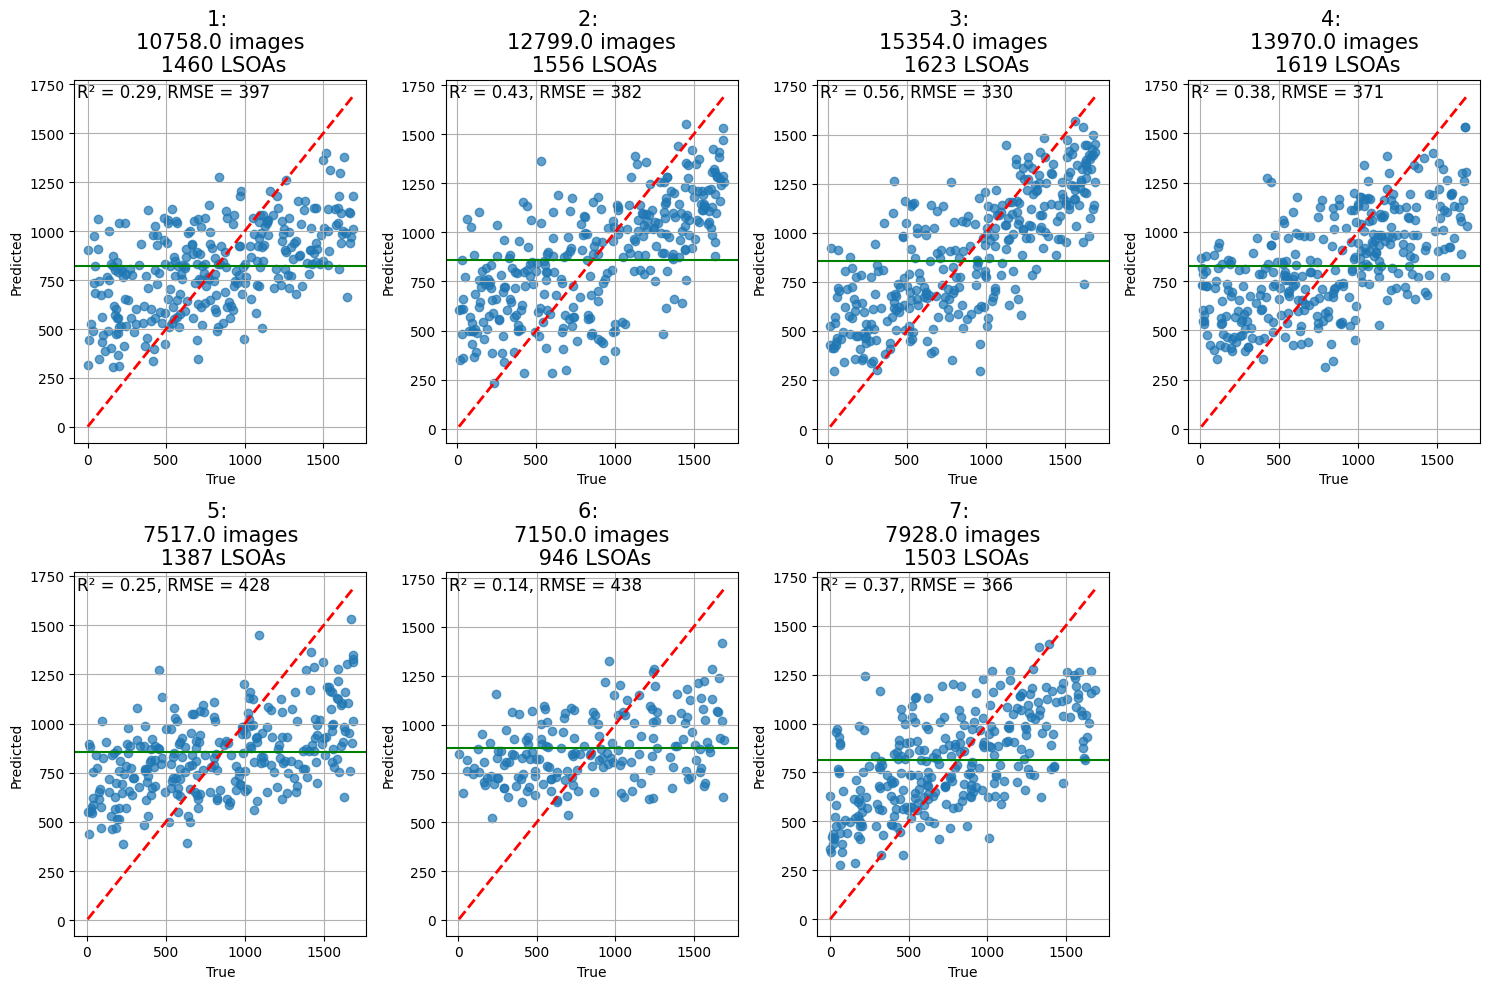

In [33]:
fig, axs=plt.subplots(ncols=4, nrows=2, figsize=(15,10))
axs=axs.flatten()
i=0
for cluster_num in range(1,k+1) :
    column = f'{cluster_num}_mean'
    column_two = f'count_{cluster_num}'
    one_image_type = summary_df_with_imd[["LSOA21CD", column, column_two, "imd_rerank"]].copy()
    num_in_class = one_image_type[column_two].sum()
    # Missing indicator
    one_image_type["missing"] = one_image_type[column].apply(is_missing_embedding).astype(int)

    # Replace missing scalar 0 with a 512-dim zero vector
    #one_image_type[column] = one_image_type[column].apply(
    #    lambda x: np.zeros(512) if is_missing_embedding(x) else x)

    one_image_type = one_image_type.sort_values("LSOA21CD").reset_index(drop=True)

    # Get rid of LSOAs with missing embeddings
    one_image_type = one_image_type[one_image_type['missing']==0]
    print(f"{cluster_num}, {len(one_image_type)}")
    num_lsoas = len(one_image_type)    
    
    # Get response and predictor variables 
    X_emb = np.stack(one_image_type[column].values)  
    X_missing = one_image_type[["missing"]].values        
    X = np.hstack([X_emb, X_missing])
    
    y = one_image_type["imd_rerank"].values

    # Train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Fit a model (Random Forest Regressor example)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Usage example:
    metrics = evaluate_imd_model(y_test, y_pred, cluster_num, num_in_class, num_lsoas, plot=False, plot_collectively =True, ax=axs[i])
    axs[i].axhline(y=one_image_type['imd_rerank'].mean(), color='green', linestyle='-')
        
    
    i=i+1
    
for j in range(i, len(axs)):
    axs[j].axis("off")

    fig.tight_layout()

1, 1282
2, 1628
3, 1558
4, 1618
5, 1232
6, 1537
7, 916


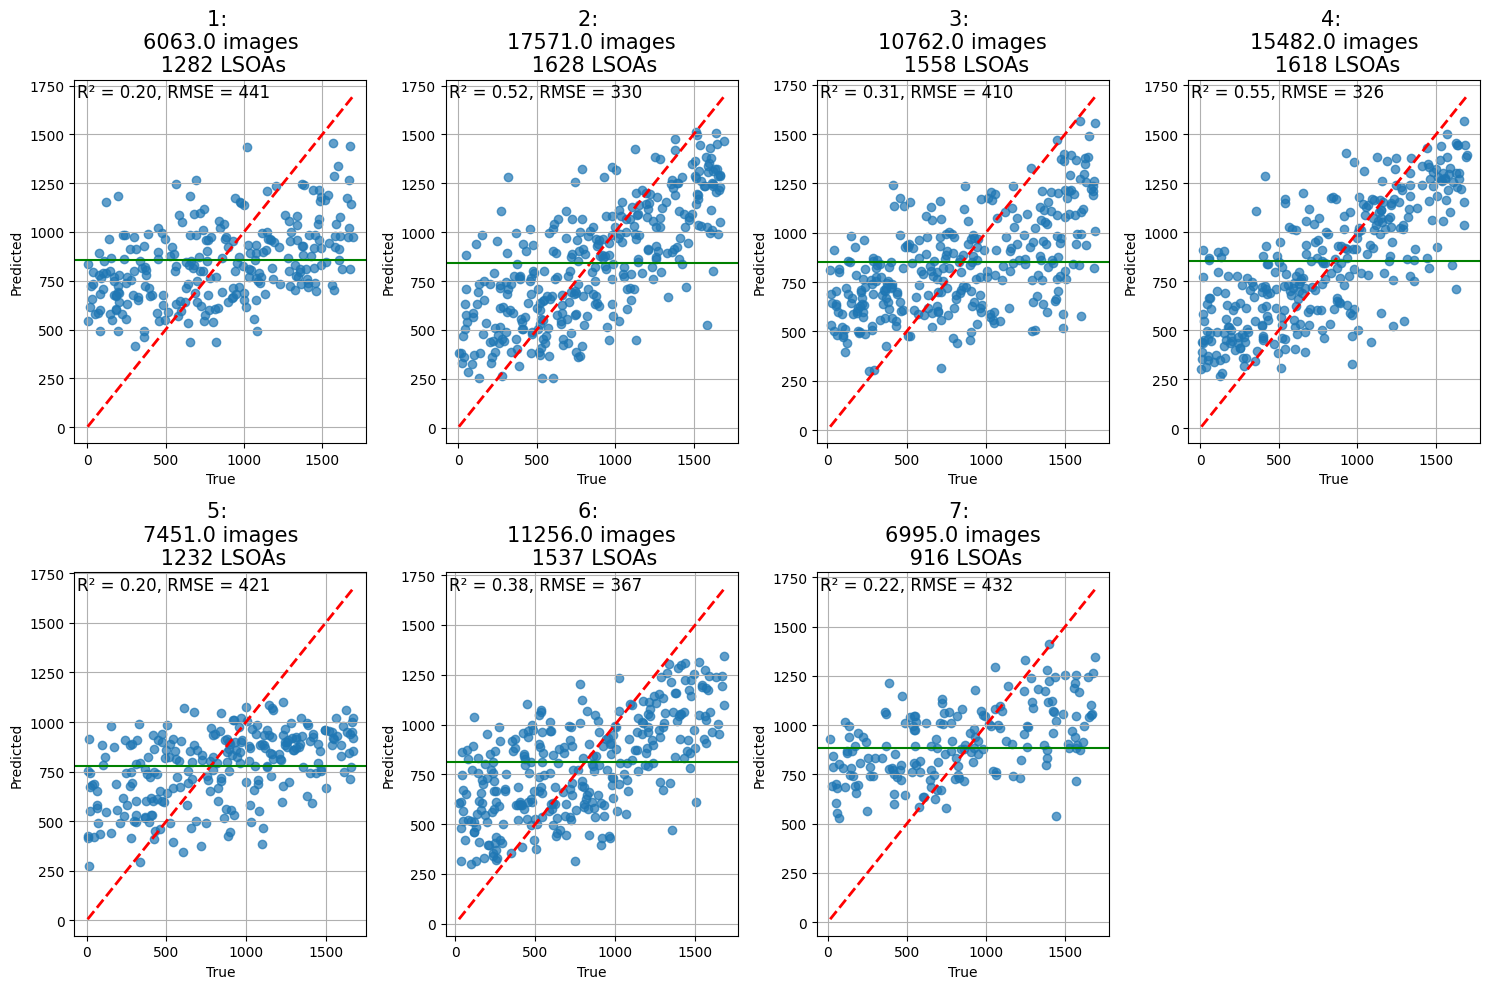

In [15]:
fig, axs=plt.subplots(ncols=4, nrows=2, figsize=(15,10))
axs=axs.flatten()
i=0
for cluster_num in range(1,k+1) :
    column = f'{cluster_num}_mean'
    column_two = f'count_{cluster_num}'
    one_image_type = summary_df_with_imd[["LSOA21CD", column, column_two, "imd_rerank"]].copy()
    num_in_class = one_image_type[column_two].sum()
    # Missing indicator
    one_image_type["missing"] = one_image_type[column].apply(is_missing_embedding).astype(int)

    # Replace missing scalar 0 with a 512-dim zero vector
    #one_image_type[column] = one_image_type[column].apply(
    #    lambda x: np.zeros(512) if is_missing_embedding(x) else x)

    one_image_type = one_image_type.sort_values("LSOA21CD").reset_index(drop=True)

    # Get rid of LSOAs with missing embeddings
    one_image_type = one_image_type[one_image_type['missing']==0]
    print(f"{cluster_num}, {len(one_image_type)}")
    num_lsoas = len(one_image_type)    
    
    # Get response and predictor variables 
    X_emb = np.stack(one_image_type[column].values)  
    X_missing = one_image_type[["missing"]].values        
    X = np.hstack([X_emb, X_missing])
    
    y = one_image_type["imd_rerank"].values

    # Train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Fit a model (Random Forest Regressor example)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Usage example:
    metrics = evaluate_imd_model(y_test, y_pred, cluster_num, num_in_class, num_lsoas, plot=False, plot_collectively =True, ax=axs[i])
    axs[i].axhline(y=one_image_type['imd_rerank'].mean(), color='green', linestyle='-')
        
    
    i=i+1
    
for j in range(i, len(axs)):
    axs[j].axis("off")

    fig.tight_layout()